In [1]:
import sys
sys.path.insert(0, '..')

import multiprocessing as mp


In [2]:
from database.dataset import INBreast_Dataset
from general_utils.metrics import circle_comparison, quick_circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from mc_detection.morphology_detection import MorphologyDetection
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np

from skimage import restoration


In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=2.0, #max 315 pixels area
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    partitions = ['train'],
    n_jobs=-1,
    lesion_types=['calcification', 'cluster'],
    return_indexes_in_mask=True)


In [5]:
rbd_path = Path('/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/')

md = MorphologyDetection(rbd_path, 0.97)

## Single image test

This section is used for testing individual detection steps. Infore it if need general results

In [4]:
def min_max_norm(img):
        return (img - img.min())/(img.max() - img.min())
def to_uint8(img):
        return (255*min_max_norm(img)).astype(np.uint8)
def sobel_gradient(img):
        grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        grad = np.sqrt(grad_x**2 + grad_y**2)
        return grad


In [7]:
idx = 141
image = db[idx]['img']
image_id = db.df.iloc[idx].img_id
image_mask = db[idx]['lesion_mask']
image_mask = cv2.dilate(image_mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)))
true_bboxes = db[idx]['lesion_bboxes']
selected_cc_mask = md.detect(image, image_id)
selected_cc = np.unique(selected_cc_mask)

TP_mask = (selected_cc_mask > 0) & (image_mask > 0)
TP = np.unique(image_mask[TP_mask])

img_res = {'img_id': image_id, 'TP': len(TP), 'FP': len(selected_cc) - len(TP),
            'FN': len(np.unique(image_mask)) - len(TP) - 1}
img_res

{'img_id': 24065557, 'TP': 4, 'FP': 7232, 'FN': 2}

In [8]:
# intensity thresholding 
rbd_image_no_bbound = cv2.imread(f'/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/{image_id}.tiff', cv2.IMREAD_ANYDEPTH)
trheshold = np.quantile(rbd_image_no_bbound[rbd_image_no_bbound!=0].ravel(), q=0.97)
thr1_rbd = rbd_image_no_bbound.copy()
thr1_rbd[thr1_rbd <= trheshold] = 0
cc_mask = md.connected_components_extraction(thr1_rbd)

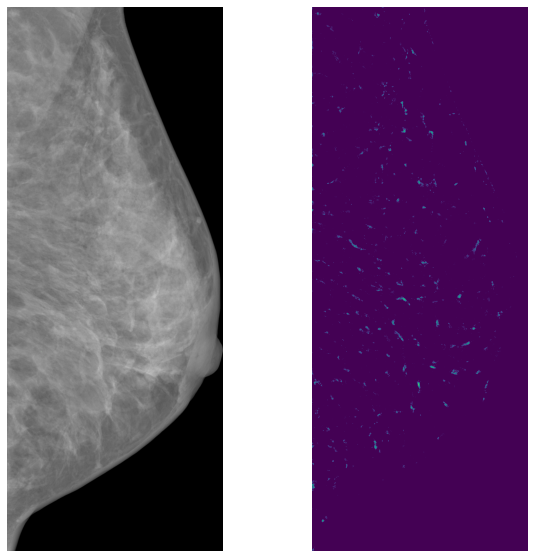

True

In [9]:
img_rois = plot_bboxes_over_image(image, [true_bboxes], [(0, 255, 0)], ['rect'])
simple_im_show2(img_rois, thr1_rbd)
cv2.imwrite('bad_test_img.tiff', img_rois)
cv2.imwrite('thr1_rbd.tiff', cc_mask)

## All dataset test

In [10]:
res = []

for idx in tqdm(range(len(db))):
    image = db[idx]['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db[idx]['lesion_mask']
    image_mask = cv2.dilate(image_mask, cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3)))

    selected_cc_mask = md.detect(image, image_id)
    selected_cc = np.unique(selected_cc_mask)

    TP_mask = (selected_cc_mask > 0) & (image_mask > 0)
    TP = np.unique(image_mask[TP_mask])

    img_res = {'img_id': image_id, 'TP': len(TP), 'FP': len(selected_cc) - len(TP),
               'FN': len(np.unique(image_mask)) - len(TP) - 1}
    res.append(img_res)


100%|██████████| 163/163 [02:26<00:00,  1.11it/s]


<IPython.core.display.Javascript object>

<AxesSubplot:>

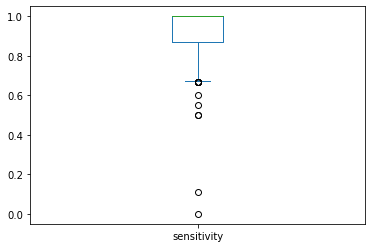

In [11]:
res_df = pd.DataFrame(res)
res_df['sensitivity'] = res_df.TP / (res_df.TP + res_df.FN)
res_df.sensitivity.plot.box()

<AxesSubplot:ylabel='Frequency'>

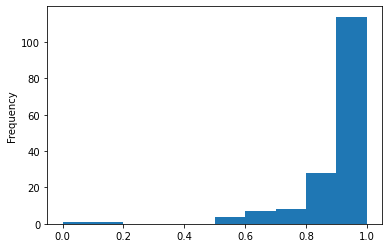

In [12]:
res_df['sensitivity'].T.plot.hist()

<IPython.core.display.Javascript object>

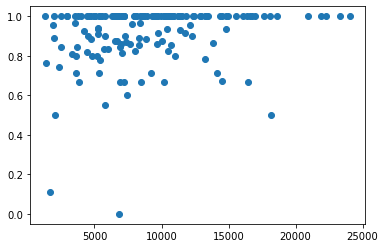

In [13]:
plt.scatter(res_df.FP.values, res_df.sensitivity.values)


In [14]:
res_df.sort_values(by=['sensitivity'])

,img_id,TP,FP,FN,sensitivity
9,20587320,0,6862,5,0.000000
11,20587466,4,1707,32,0.111111
83,22670147,1,18183,1,0.500000
151,26933772,2,2077,2,0.500000
126,24055806,54,5800,44,0.551020
...,...,...,...,...,...
85,22670301,4,2968,0,1.000000
84,22670177,2,18581,0,1.000000
82,22670124,4,7143,0,1.000000
34,22427728,3,23293,0,1.000000


In [15]:
res_df.sensitivity.mean()

0.9157969600014431

<AxesSubplot:ylabel='Frequency'>

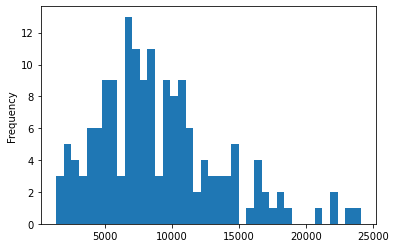

In [16]:
(res_df.TP +res_df.FP).plot.hist(bins=40)

In [17]:
(res_df.TP +res_df.FP).mean()

8964.638036809816

In [18]:
res_df.sort_values(by=['sensitivity']).head(40)

,img_id,TP,FP,FN,sensitivity
9,20587320,0,6862,5,0.000000
11,20587466,4,1707,32,0.111111
83,22670147,1,18183,1,0.500000
151,26933772,2,2077,2,0.500000
126,24055806,54,5800,44,0.551020
73,22614353,3,7394,2,0.600000
10,20587346,2,10200,1,0.666667
30,20588562,4,6875,2,0.666667
31,20588654,2,8455,1,0.666667
35,22427751,4,16415,2,0.666667
